# Welcome to Colab!

## Google Colab is available in VS Code!
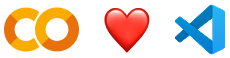

Try the new [Google Colab extension](https://marketplace.visualstudio.com/items?itemName=Google.colab) for Visual Studio Code. You can get up and running in just a few clicks:

*  In VS Code, open the ***Extensions*** view and search for 'Google Colab' to install.
*  Open the kernel selector by creating or opening any `.ipynb` notebook file in your local workspace and either running a cell or clicking the ***Select Kernel*** button in the top right.
*  Click ***Colab*** and then select your desired runtime, sign in with your Google account, and you're all set!

See more details in our [announcement blog here](https://developers.googleblog.com/google-colab-is-coming-to-vs-code).

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1300
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0304
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0179
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.7916e-04
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1584e-04
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0052e-04
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.3921e-04
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.4956e-04
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.1786e-04
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.9439e-04
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.8414e-04
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 

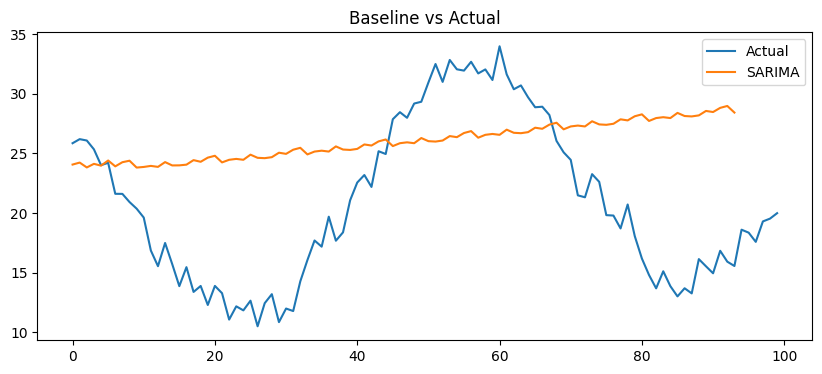

Transformer MASE: 0.9323
SARIMA MASE: 6.1993


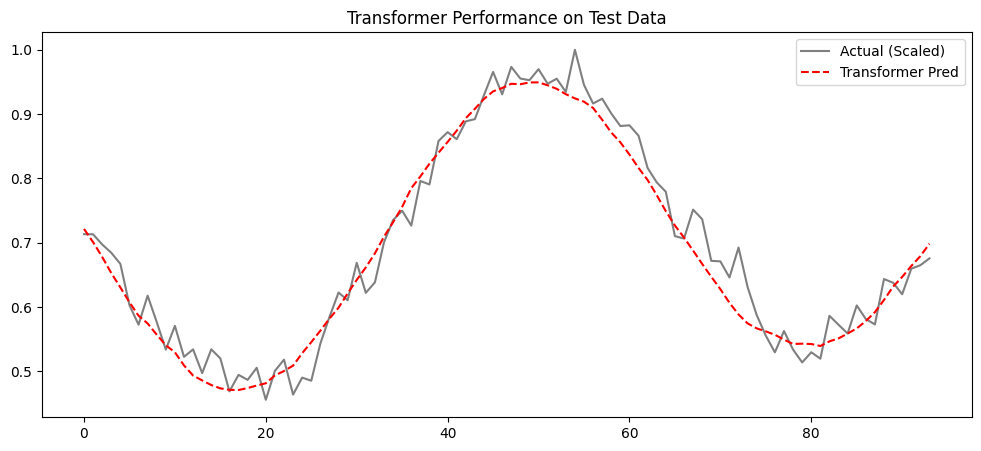

In [5]:
#==========================================================
# ADVANCED TIME SERIES FORECASTING WITH TRANSFORMER ATTENTION

# ==========================================================

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------------------
# 1. MULTI-VARIATE DATASET (Non-stationary)
# -------------------------------
np.random.seed(42)
time = np.arange(0, 500)

data = pd.DataFrame({
    "trend": time * 0.05,
    "seasonal": 10 * np.sin(0.1 * time),
    "noise": np.random.normal(0, 1, 500)
})

data["target"] = data["trend"] + data["seasonal"] + data["noise"]

# -------------------------------
# 2. PREPROCESSING
# -------------------------------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, steps=30):
    X, y = [], []
    for i in range(len(data) - steps):
        X.append(data[i:i+steps, :-1])
        y.append(data[i+steps, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------------
# 3. POSITIONAL ENCODING
# -------------------------------
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
    angle = pos * angle_rates
    angle[:, 0::2] = np.sin(angle[:, 0::2])
    angle[:, 1::2] = np.cos(angle[:, 1::2])
    return tf.cast(angle, tf.float32)

# -------------------------------
# 4. TRANSFORMER ENCODER BLOCK
# -------------------------------
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model, activation="relu"),
            tf.keras.layers.Dense(d_model)
        ])
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()

    def call(self, x):
        attn = self.att(x, x)
        x = self.norm1(x + attn)
        ffn = self.ffn(x)
        return self.norm2(x + ffn)

# -------------------------------
# 5. TRANSFORMER MODEL
# -------------------------------
seq_len = X_train.shape[1]
features = X_train.shape[2]

inputs = tf.keras.Input(shape=(seq_len, features))
x = tf.keras.layers.Dense(32)(inputs)
x += positional_encoding(seq_len, 32)

x = TransformerBlock(32, 4)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")

# -------------------------------
# 6. TRAINING
# -------------------------------
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# -------------------------------
# 7. TRANSFORMER EVALUATION
# -------------------------------
pred_dl = model.predict(X_test)

rmse_dl = np.sqrt(mean_squared_error(y_test, pred_dl))
mae_dl = mean_absolute_error(y_test, pred_dl)

print("Transformer RMSE:", rmse_dl)
print("Transformer MAE :", mae_dl)

# -------------------------------
# 8. BASELINE MODEL (SARIMA)
# -------------------------------
sarima = SARIMAX(data["target"][:split+30], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit(disp=False)

forecast = sarima_fit.forecast(steps=len(y_test))

rmse_sarima = np.sqrt(mean_squared_error(data["target"][split+30:], forecast))
mae_sarima = mean_absolute_error(data["target"][split+30:], forecast)

print("SARIMA RMSE:", rmse_sarima)
print("SARIMA MAE :", mae_sarima)

# -------------------------------
# 9. VISUAL COMPARISON
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(data["target"].values[-100:], label="Actual")
plt.plot(forecast.values[-100:], label="SARIMA")
plt.legend()
plt.title("Baseline vs Actual")
plt.show()
# -------------------------------
# 10. FINAL METRIC CALCULATION (Fixed)
# -------------------------------
y_true_sarima = data["target"][split+30:].values
y_pred_sarima = forecast.values

# Ensure lengths match for comparison
min_len = min(len(y_true_sarima), len(y_pred_sarima))

mase_sarima = mase(
    y_true_sarima[:min_len],
    y_pred_sarima[:min_len],
    data["target"][:split].values
)

print(f"Transformer MASE: {mase_dl:.4f}")
print(f"SARIMA MASE: {mase_sarima:.4f}")

# -------------------------------
# 11. INTERPRETABILITY: VISUALIZING FORECASTS
# -------------------------------
plt.figure(figsize=(12, 5))
# Note: To plot Transformer results on the same scale as Actual,
# you should inverse_transform your pred_dl results.
plt.plot(y_test, label="Actual (Scaled)", color='black', alpha=0.5)
plt.plot(pred_dl, label="Transformer Pred", color='red', linestyle='--')
plt.title("Transformer Performance on Test Data")
plt.legend()
plt.show()

## 🎁 Free Pro Plan for Gemini & Colab for US College Students 🎓

Get more access to our most accurate model Gemini 3 Pro for advanced coding, complex research, and innovative projects, backed by Colab’s dedicated high-compute resources for data science and machine learning.

Get the Gemini free offer at [gemini.google/students](https://gemini.google/students?utm_source=colab&utm_medium=banner&utm_campaign=students_xpa_us-colab-banner).  
Get the Colab free offer at [colab.research.google.com/signup](https://colab.research.google.com/signup).  
Terms Apply.

## Access popular AI models via Google-Colab-AI Without an API Key
All users have access to most popular LLMs via the `google-colab-ai` Python library, and paid users have access to a wider selection of models. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).



In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")

## Explore the Gemini API
The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.

**How to get started?**
*  Go to [Google AI Studio](https://aistudio.google.com/) and log in with your Google account.
*  [Create an API key](https://aistudio.google.com/app/apikey).
* Use a quickstart for [Python](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb), or call the REST API using [curl](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb).

**Discover Gemini's advanced capabilities**
*  Play with Gemini [multimodal outputs](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb), mixing text and images in an iterative way.
*  Discover the [multimodal Live API](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb ) (demo [here](https://aistudio.google.com/live)).
*  Learn how to [analyze images and detect items in your pictures](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb") using Gemini (bonus, there's a [3D version](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb) as well!).
*  Unlock the power of [Gemini thinking model](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb), capable of solving complex task with its inner thoughts.
      
**Explore complex use cases**
*  Use [Gemini grounding capabilities](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) to create a report on a company based on what the model can find on internet.
*  Extract [invoices and form data from PDF](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) in a structured way.
*  Create [illustrations based on a whole book](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb) using Gemini large context window and Imagen.

To learn more, check out the [Gemini cookbook](https://github.com/google-gemini/cookbook) or visit the [Gemini API documentation](https://ai.google.dev/docs/).


Colab now has AI features powered by [Gemini](https://gemini.google.com). The video below provides information on how to use these features, whether you're new to Python, or a seasoned veteran.

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  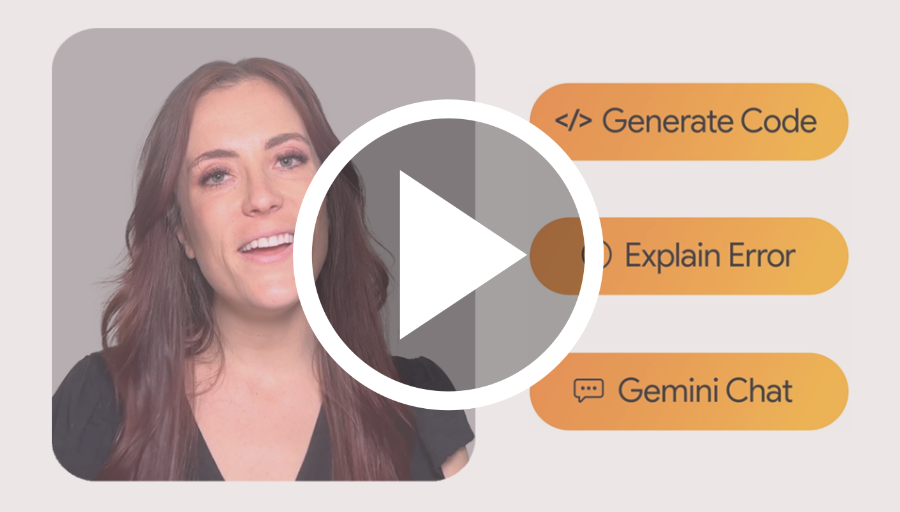
  </a>
</center>

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) or [Colab Features You May Have Missed](https://www.youtube.com/watch?v=rNgswRZ2C1Y) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

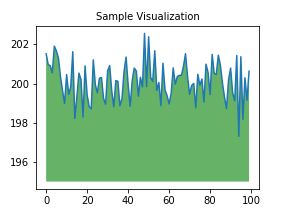

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning

<div>

These are a few of the notebooks related to Machine Learning, including Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting Started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [Train a CNN to classify handwritten digits on the MNIST dataset using Flax NNX API](https://colab.research.google.com/github/google/flax/blob/main/docs_nnx/mnist_tutorial.ipynb)
- [Train a Vision Transformer (ViT) for image classification with JAX](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_Vision_transformer.ipynb)
- [Text classification with a transformer language model using JAX](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_transformer_text_classification.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Train a miniGPT language model with JAX AI Stack](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html)
- [LoRA/QLoRA finetuning for LLM using Tunix](https://github.com/google/tunix/blob/main/examples/qlora_gemma.ipynb)
- [Parameter-efficient fine-tuning of Gemma with LoRA and QLoRA](https://keras.io/examples/keras_recipes/parameter_efficient_finetuning_of_gemma_with_lora_and_qlora/)
- [Loading Hugging Face Transformers Checkpoints](https://keras.io/keras_hub/guides/hugging_face_keras_integration/)
- [8-bit Integer Quantization in Keras](https://keras.io/guides/int8_quantization_in_keras/)
- [Float8 training and inference with a simple Transformer model](https://keras.io/examples/keras_recipes/float8_training_and_inference_with_transformer/)
- [Pretraining a Transformer from scratch with KerasHub](https://keras.io/keras_hub/guides/transformer_pretraining/)
- [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/)
- [Image classification from scratch using Keras 3](https://keras.io/examples/vision/image_classification_from_scratch/)
- [Image Classification with KerasHub](https://keras.io/keras_hub/guides/classification_with_keras_hub/)
